# Major Findings: 
In analyzing the relationship between median wages, projected openings for occupations and the probability of automation three major relationships are discovered:
    1.	Occupations with the highest median wages have the least threat of automation, and many occupations with very low median  wages have extremely high likelihood of being automated.
    2.	Jobs that have a high probability of being automated tend to have very low median annual wages.
    3.	Jobs that have a very high likelihood of automation are projected to have many openings.
    
These three relationship working together most likely mean that many occupations with low median wages are going to suffer from job losses from automation, but many fields losing jobs to automation might not be replacing any workers.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [2]:
#import the bls dataset that will anchor all other datasets, going to merge by national employmnent
#matrix title

bls_occupation_df=pd.read_csv('~/OneDrive/desktop/bootcamp/occupation_complete.csv')

In [53]:
#Bring in the dataset that has automation scores and states

automation_score_df=pd.read_csv('~/OneDrive/desktop/bootcamp/automation_score_state.csv')

In [54]:
#change columns I want to merge by occupation to "National Employment Matrix title code"
#also I want to change titles to occupation
bls_occupation_df = bls_occupation_df.rename(columns={'2022 National Employment Matrix code':
                                                      'National Employment Matrix code',
                                                      '2022 National Employment Matrix title':
                                                      'Occupation'})
automation_score_df = automation_score_df.rename(columns={'SOC':
                                                          'National Employment Matrix code'})

In [55]:
#merge the two dataframes on National Employment Matrix title
#using inner join so only the occupations with an automation score are kept
merged_automation_score_df = pd.merge(bls_occupation_df, 
                                      automation_score_df,
                                      on='National Employment Matrix code',
                                      how='inner')

In [56]:
#clean occupation duplicate
#get rid of occupation y column
del merged_automation_score_df['Occupation_y']

#rename occupation x column
merged_automation_score_df = merged_automation_score_df.rename(columns={'Occupation_x':
                                                                        'Occupation'})

In [57]:
#bring in dataset with utilzation output from BLS
utilization_df=pd.read_csv('~/OneDrive/desktop/bootcamp/Utilization.csv')#clean up this dataframe, we are interested in bringing in "Factors Affecting..." column

occupation_projections_df = utilization_df[['2022 National Employment Matrix occupation code',
                                          'Factors affecting occupational utilization']]

#rename the two columns for merge and to make easier to understand

occupation_projections_df = occupation_projections_df.rename(columns={'2022 National Employment Matrix occupation code':
                                                                      'National Employment Matrix code',
                                                                      'Factors affecting occupational utilization':
                                                                      'Occupation Projections'})

In [58]:
#merge the two dataframes on National Employment Matrix title
#using inner join so only the occupations with an automation score are kept
automation_df = pd.merge(occupation_projections_df, 
                         merged_automation_score_df,
                         on='National Employment Matrix code',
                         how='inner')
columns = automation_df.columns

In [59]:
#After analysis, we do not need the states, so I will reduce the number of columns
automation_df = automation_df[['National Employment Matrix code',
                               'Occupation Projections',
                               'Occupation',
                               'Occupation type',
                               'Employment, 2022',
                               'Employment, 2032',
                               'Employment change, numeric, 2022-32',
                               'Employment change, percent, 2022-32',
                               'Percent self employed, 2022',
                               'Occupational openings, 2022-32 annual average',
                               'Median annual wage, 2022(1)',
                               'Typical education needed for entry',
                               'Work experience in a related occupation',
                               'Typical on-the-job training needed to attain competency in the occupation',
                               'Probability']]

In [60]:
#Need to remove $, commas and change string to integers for some columns
automation_df['Employment change, percent, 2022-32'] = pd.to_numeric(automation_df['Employment change, percent, 2022-32'])

In [61]:
#on scatter graphs I want to scale the size of the dots to the number of jobs in the professions
#regular sclaing mruins the graph, so I used a natural log scale
automation_df['Natural Log Of Current Employment'] = np.log(automation_df['Employment, 2022'])

C:\Users\Bryson\anaconda3\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\Bryson\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


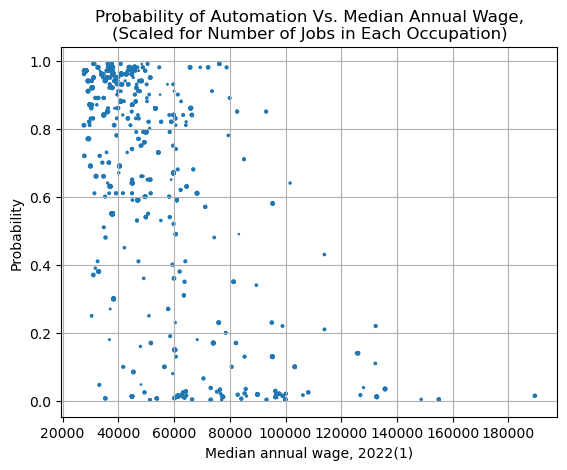

rvalue:-0.6151340893204027


In [62]:
#run a simple linear regression betweem probability of automation and median annual wage

from scipy.stats import linregress

x_values = automation_df['Median annual wage, 2022(1)']
y_values = automation_df['Probability']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)



automation_df.plot(kind="scatter",x="Median annual wage, 2022(1)",
                   y='Probability',
                   s=automation_df['Natural Log Of Current Employment'],
                   grid=True,
                   title = "Probability of Automation Vs. Median Annual Wage,\n(Scaled for Number of Jobs in Each Occupation)")
plt.show()
print(f"rvalue:{rvalue}")

# Graph Explanation

Median Annual Wages v Probability of being Automated: There is a very clear trend here, jobs that have higher median wages tend to require skills that are gained from higher levels of education and are difficult to automate.

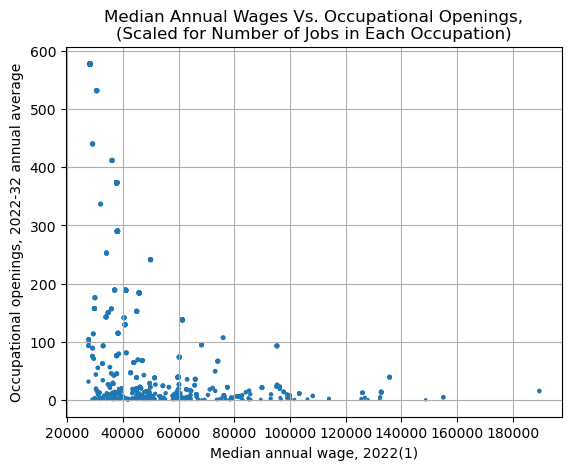

In [63]:
#takeaway, the number of jobs with the most openings are more often than not low paying

automation_df.plot(kind="scatter",x="Median annual wage, 2022(1)",
                         y='Occupational openings, 2022-32 annual average',
                         s=automation_df['Natural Log Of Current Employment'],
                         grid=True,
                         title = "Median Annual Wages Vs. Occupational Openings,\n(Scaled for Number of Jobs in Each Occupation)")
plt.show()

# Graph Explanation
Median Annual Wages v Occupation Openings: The takeaway here is twofold: workers are staying away from jobs they think will be automated and jobs that have a shortage of workers will look to automation to fill the void

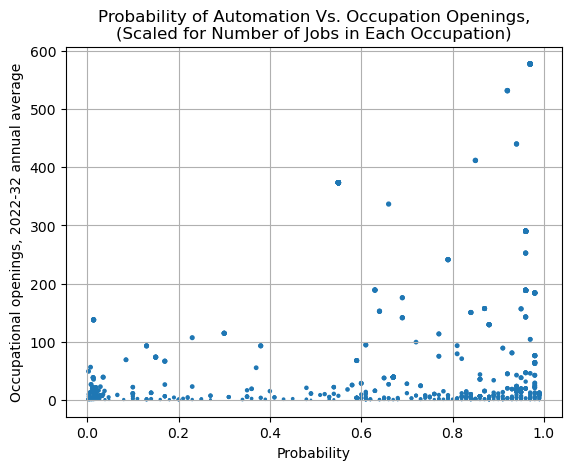

In [64]:
#takeaway, the occupations with a lot of current openings are often the most likely to be automated:
# looks like we have a chicken and an egg problem with why this is
# theory 1: workers have begun moving away and will stay away from jobs they think will be automated
# theory 2: workers cannot be found for particular occupations so it is reasonable to automate that job

automation_df.plot(kind="scatter",x="Probability",
                         y='Occupational openings, 2022-32 annual average',
                         s=automation_df['Natural Log Of Current Employment'],
                         grid=True,
                         title = "Probability of Automation Vs. Occupation Openings,\n(Scaled for Number of Jobs in Each Occupation)")
plt.show()

# Graph Explanation

Probability of Automation v Occupation Openings: The main takeaway here is that workers are staying away from low paying jobs when they have other options.

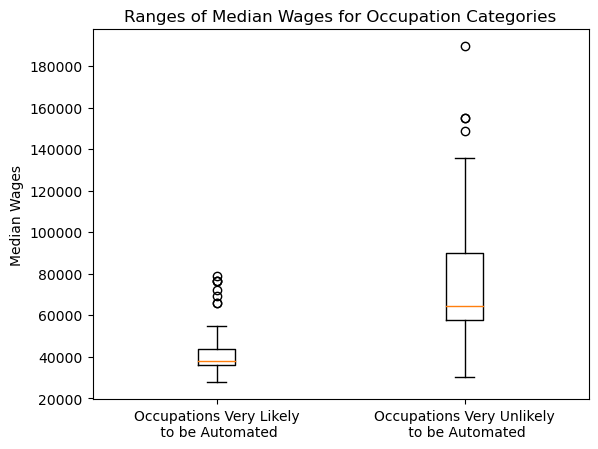

In [65]:
#show boxplots (I kept the graph with outliers so you can see the range of very high paying jobs)
#what occupations are extremely likely to be automated
likely_to_be_automated_df = automation_df[automation_df['Probability'] > .95]
unlikely_to_be_automated_df = automation_df[automation_df['Probability'] < .50]

#create series of the median wages of both above dataframes for a side by side boxplot 
median_wage_likely = likely_to_be_automated_df['Median annual wage, 2022(1)']
median_wage_unlikely = unlikely_to_be_automated_df['Median annual wage, 2022(1)']


data = [median_wage_likely, median_wage_unlikely]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['Occupations Very Likely\n to be Automated', 'Occupations Very Unlikely\n to be Automated'])
ax.set_ylabel('Median Wages')
ax.set_title('Ranges of Median Wages for Occupation Categories')
plt.show()

# Graph Explanation
This Box Plot shows the median annual wages of jobs that are more than 95% likely to have significant automation in the field compared too the occupations less than 50% likely to have significant automation. This reinforces that low-paying jobs have an over-lap with low-skilled jobs that are most likely to be automated.

In [66]:
#start working on education leevl analysis 
#Create a table so we can see the job gains over the next ten years per degree level, in total terms
job_gains_by_education = automation_df.groupby('Typical education needed for entry')['Employment change, numeric, 2022-32'].sum()
job_gains_by_education_df = job_gains_by_education.reset_index()
job_gains_by_education_df

,Typical education needed for entry,"Employment change, numeric, 2022-32"
0,Associate's degree,267.5
1,Bachelor's degree,1368.2
2,Doctoral or professional degree,330.4
3,High school diploma or equivalent,-9835.2
4,Master's degree,301.2
5,No formal educational credential,-6081.9
6,Postsecondary nondegree award,1099.1
7,"Some college, no degree",-935.6


In [67]:
#clean up and reorganize the table
#Looking at the documentation for the original dataset, there is a misconnect in the job projects
#talk about why that is, how that stoppped me from continuing down the ecducation level analysis path
data = {'Education Level':["No High School Diploma","High School Diploma","Some College","Postsecondary Award",
                           "Associate's Degree", "Bachelor's Degree", "Master's Degree", "Doctoral"],
        "Job_Gains_2022-2032":[-6082900, -9837200, -935600, 1098500, 266900, 1367700, 300400, 330900]}
job_gains_by_degree_df = pd.DataFrame(data)
job_gains_by_degree_df

,Education Level,Job_Gains_2022-2032
0,No High School Diploma,-6082900
1,High School Diploma,-9837200
2,Some College,-935600
3,Postsecondary Award,1098500
4,Associate's Degree,266900
5,Bachelor's Degree,1367700
6,Master's Degree,300400
7,Doctoral,330900


In [68]:
#Build a tool that offers suggestions for a new occupation if a current occupation is likely to be automated
#I want to change the education level from a string to a ranked integer for matching 
automation_df['Education Code'] = automation_df['Typical education needed for entry'].replace({
              'No formal educational credential':1,
              'High school diploma or equivalent':2,
              'Some college, no degree':3,
              'Postsecondary nondegree award':4,
              "Associate's degree":5, 
              "Bachelor's degree":6,
              "Master's degree":7,
              'Doctoral or professional degree':8})

In [69]:
#I also want to add a new column that has occupation prefix, occupations with matching pre-fixes are in similar fields
automation_df['National Employment Matrix code'] = automation_df['National Employment Matrix code'].str.split('-').str.get(0)

In [70]:
#theere are spaces before the occupation projects data that need to be removed
automation_df['Occupation'] = automation_df['Occupation'].str.strip()

In [71]:
#talk about why we chose .7, comes from the paper by the economists
above_70_automation_df = automation_df[automation_df['Probability'] >= .7]
below_70_automation_df = automation_df[automation_df['Probability'] < .699]

In [72]:
#bring in the random function that chooses an occupation from the dataframe very likely to be automated 
import random
random_index = random.randint(0, len(above_70_automation_df) - 1)
random_row = above_70_automation_df.iloc[random_index]

#assign variables to the sleected occupation so we can cross-reference with the dataframe of not likely automated jobs
selected_wages = random_row['Median annual wage, 2022(1)']
selected_education_code = random_row['Education Code']
selected_prefix = random_row['National Employment Matrix code']

#print out some info about the occupation likely to be automated
print(f"{random_row['Occupation']} had a median annual wage of {random_row['Median annual wage, 2022(1)']} in 2o22.")
print(f"There is a {random_row['Probability']*100} percent chance that this occupation experiences intense job loss due to automation by 2023.")
print(f"A typical {random_row['Occupation']} worker needs a {random_row['Typical education needed for entry']}.")
print(f"The Bureau of Labor and Statistics porjects the following demand changes by 2032:\n{random_row['Occupation Projections']}")

#create a dataframe of possible replacement jobs that match the same field as the old occupation
#the possible new occupations should pay at least 80% of the old job
#the new occupations cannot require a higher typical degree than the old job
options_df = below_70_automation_df[(below_70_automation_df['National Employment Matrix code'] == selected_prefix) &
                                    (below_70_automation_df['Median annual wage, 2022(1)'] > .8*selected_wages) &
                                    (below_70_automation_df['Education Code'] <= selected_education_code)]
sorted_options_df = options_df.sort_values(by="Median annual wage, 2022(1)", ascending=False)
reset_sorted_options_df = sorted_options_df.set_index('Median annual wage, 2022(1)').reset_index()


#in the situation where the dataframe above is too restrictive and less than 2 results arew returned
#create a new dataframe where the new job does not have to be in the same field as the old job
#the restirctions will be greater than 80% wages of the old job, less than 120% wages of the old job
#and the same typical degree as the old job

options_loose_requirements_df = below_70_automation_df[(below_70_automation_df['Median annual wage, 2022(1)'] > .8*selected_wages) &
                                    (below_70_automation_df['Education Code'] <= selected_education_code)]
options_loose_requirements_df = options_loose_requirements_df.sort_values(by="Median annual wage, 2022(1)", ascending=False)
reset_sorted_options_loose_df = options_loose_requirements_df.set_index('Median annual wage, 2022(1)').reset_index()

#I am going to count the number of rows for both new dataframes so I can devide which dataframe to use 
num_rows_options = len(reset_sorted_options_df)

#assign variable fromm the two dataframes for prinrting new occupation options
if num_rows_options >2:
    first_option_occupation = reset_sorted_options_df.at[0,"Occupation"]
    second_option_occupation = reset_sorted_options_df.at[1,"Occupation"]
    third_option_occupation = reset_sorted_options_df.at[2,"Occupation"]
    first_option_wages = reset_sorted_options_df.at[0,"Median annual wage, 2022(1)"]
    second_option_wages = reset_sorted_options_df.at[1,"Median annual wage, 2022(1)"]
    third_option_wages = reset_sorted_options_df.at[2,"Median annual wage, 2022(1)"]
else:
    first_loose_option_occupation = reset_sorted_options_loose_df.at[0,"Occupation"]
    second_loose_option_occupation = reset_sorted_options_loose_df.at[1,"Occupation"]
    third_loose_option_occupation = reset_sorted_options_loose_df.at[2,"Occupation"]
    first_loose_option_wages = reset_sorted_options_loose_df.at[0,"Median annual wage, 2022(1)"]
    second_loose_option_wages = reset_sorted_options_loose_df.at[1,"Median annual wage, 2022(1)"]
    third_loose_option_wages = reset_sorted_options_loose_df.at[2,"Median annual wage, 2022(1)"]



if num_rows_options >2:
    print()
    print()
    print(f"Possible new occupation are:")
    print(f"{first_option_occupation}, with a median annual wage of {first_option_wages}")
    print(f"{second_option_occupation}, with a median annual wage of {second_option_wages}")
    print(f"{third_option_occupation}, with a median annual wage of {third_option_wages}")
else:
    print()
    print()
    print(f"Possible new occupation are:")
    print(f"{first_loose_option_occupation}, with a median annual wage of {first_loose_option_wages}")
    print(f"{second_loose_option_occupation}, with a median annual wage of {second_loose_option_wages}")
    print(f"{third_loose_option_occupation}, with a median annual wage of {third_loose_option_wages}")
    print(len(reset_sorted_options_df))

Cement Masons and Concrete Finishers had a median annual wage of 48300.0 in 2o22.
There is a 94.0 percent chance that this occupation experiences intense job loss due to automation by 2023.
A typical Cement Masons and Concrete Finishers worker needs a No formal educational credential.
The Bureau of Labor and Statistics porjects the following demand changes by 2032:
Sourcing change, demand change - share decreases as more precast and prefabricated concrete products are installed which is partially offset by the increased demand for polished concrete.


Possible new occupation are:
Tapers, with a median annual wage of 62360.0
Tapers, with a median annual wage of 62360.0
Tapers, with a median annual wage of 62360.0
